# Installation

In [1]:
%%capture
import sys
!{sys.executable} -m pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Python packages import

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_recall_curve,classification_report,confusion_matrix,plot_confusion_matrix 
from scipy import sparse
from sklearn.preprocessing import FunctionTransformer
from src.pre_processing import pipeline_remove_punctuations,pipeline_remove_numbers,pipeline_remove_stopwords,pipeline_word_lem,pipeline_stemmer
import string
import pickle
import re
import json
import requests

# Data Cleaning
For our analysis we use: productgroup, main_text,add_text,manufacturer .

In [3]:
data = pd.read_csv('testset_C.csv',sep=';')
data_original=data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            8000 non-null   int64 
 1   productgroup  8000 non-null   object
 2   main_text     7998 non-null   object
 3   add_text      8000 non-null   object
 4   manufacturer  6656 non-null   object
dtypes: int64(1), object(4)
memory usage: 312.6+ KB


In [4]:
# shape of data
data.shape

(8000, 5)

In [5]:
# missing values
data.isnull().sum()

id                 0
productgroup       0
main_text          2
add_text           0
manufacturer    1344
dtype: int64

In [6]:
# merging the main text and add text into single column description 
data[['main_text','add_text']] = data[['main_text','add_text']].astype(str)
data['description']=data['main_text']+' '+ data['add_text']

# remove unnecessary columns
data_analysis=data.drop(['id','main_text','add_text'],axis=1)
data_analysis.head()

,productgroup,manufacturer,description
0,WASHINGMACHINES,BOSCH,WAQ284E25 WASCHMASCHINEN
1,USB MEMORY,LEEF,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...
2,USB MEMORY,NaN,SANDISK 32GB ULTRA FIT USB 3.0 W1370
3,BICYCLES,SCHALOW & KROH GMBH,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3-GAENGE RH 5...
4,BICYCLES,DAHON,DAHON SPEED D7 SCHWARZ ? FALTRAD SPORTS__30000...


In [7]:
data_analysis.isna().sum()

productgroup       0
manufacturer    1344
description        0
dtype: int64

In [8]:
# Calculate the length of characters
data_analysis['length']=data_analysis['description'].transform(len)
data_analysis.head()

,productgroup,manufacturer,description,length
0,WASHINGMACHINES,BOSCH,WAQ284E25 WASCHMASCHINEN,24
1,USB MEMORY,LEEF,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...,139
2,USB MEMORY,NaN,SANDISK 32GB ULTRA FIT USB 3.0 W1370,36
3,BICYCLES,SCHALOW & KROH GMBH,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3-GAENGE RH 5...,100
4,BICYCLES,DAHON,DAHON SPEED D7 SCHWARZ ? FALTRAD SPORTS__30000...,65


# Data analysis

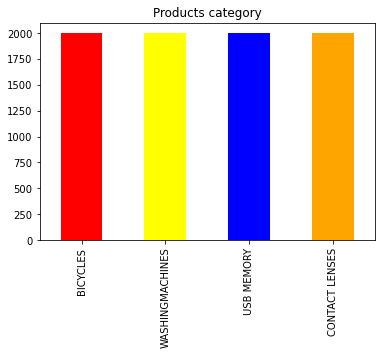

In [9]:
# check proportion productgroup variable
data['productgroup'].value_counts().plot(kind='bar', title='Products category',color=['red', 'yellow', 'blue', 'orange'])
plt.show()

In [10]:
# Names of productgroup 
data['productgroup'].unique()

array(['WASHINGMACHINES', 'USB MEMORY', 'BICYCLES', 'CONTACT LENSES'],
      dtype=object)

In [11]:
# value count for each manufacturer
data['manufacturer'].value_counts()

COOPER                   343
CIBA                     243
SIEMENS                  205
MIELE                    197
B&L                      181
                        ... 
COOPER VISION/SAUFLON      1
MEDIACOM                   1
PEACOCK                    1
LENOVO                     1
ULTRASPORT                 1
Name: manufacturer, Length: 623, dtype: int64

In [12]:
# Group by product group and count the each manufacturer per group
data.groupby(['productgroup'])['manufacturer'].value_counts()


productgroup     manufacturer         
BICYCLES         CUBE                     126
                 BERGAMONT                 80
                 SERIOUS                   71
                 GHOST                     66
                 MERIDA                    63
                                         ... 
WASHINGMACHINES  SIEMENS-Electrogeräte      1
                 SMEG                       1
                 SMEG HAUSGERAETE GMBH      1
                 TOP EDITION                1
                 UNKNOWN                    1
Name: manufacturer, Length: 630, dtype: int64

AxesSubplot(0.135,0.125;0.755x0.755)


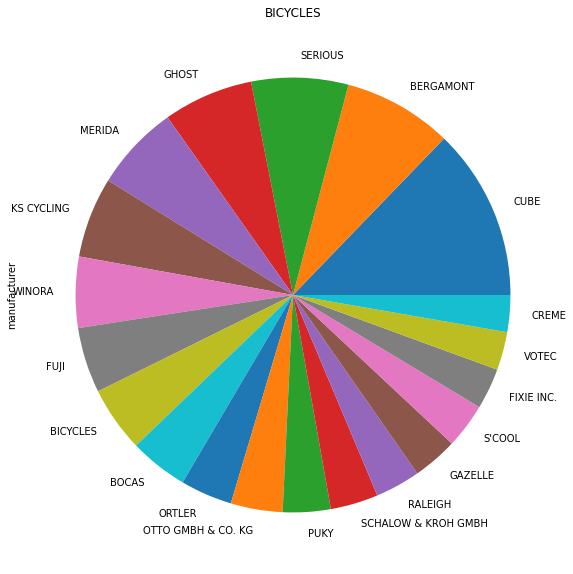

AxesSubplot(0.135,0.125;0.755x0.755)


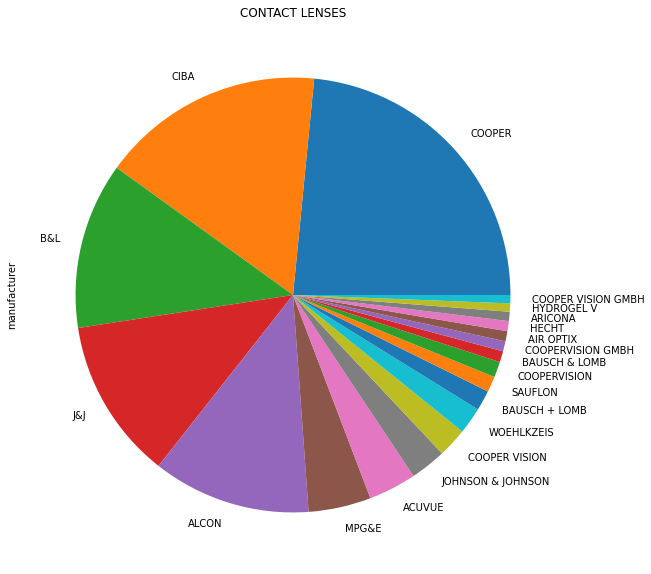

AxesSubplot(0.135,0.125;0.755x0.755)


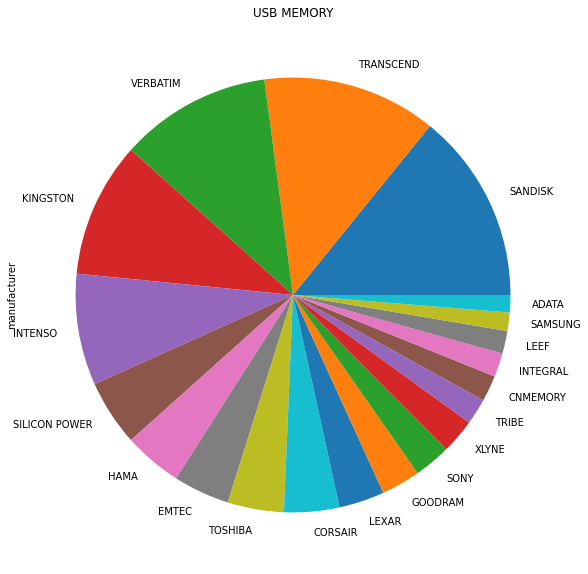

AxesSubplot(0.135,0.125;0.755x0.755)


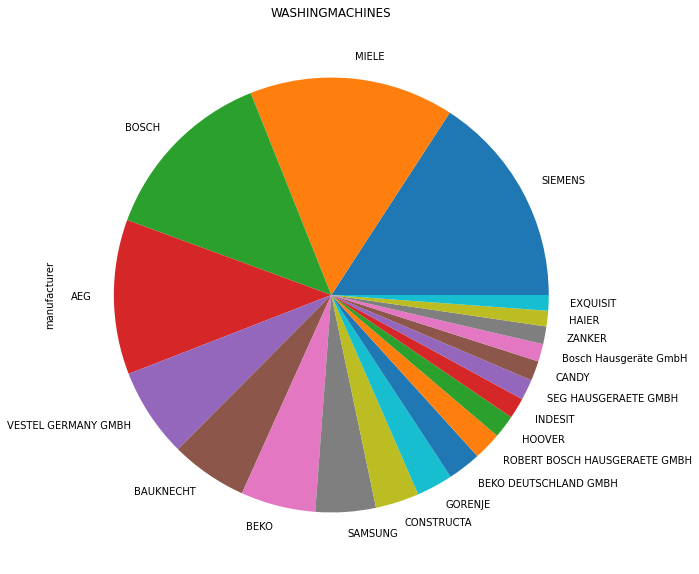

In [13]:
# Group by product group and plot top 20 manufacturer per group
group_data=data.groupby(['productgroup'])
for name,product_data in group_data:
    plt.figure(figsize=(10,10)) 
    print(product_data['manufacturer'].value_counts()[:20].plot(kind='pie', title= name))
    plt.show()

ARICONA
CONTACT LENSES    10
USB MEMORY         4
Name: productgroup, dtype: int64


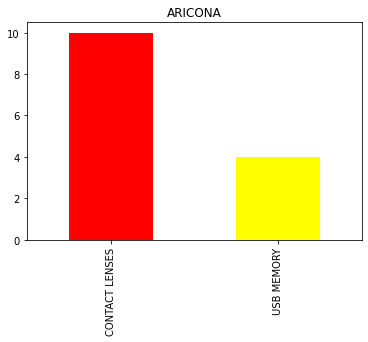

Fashion_EAN
CONTACT LENSES     4
USB MEMORY         4
WASHINGMACHINES    2
BICYCLES           2
Name: productgroup, dtype: int64


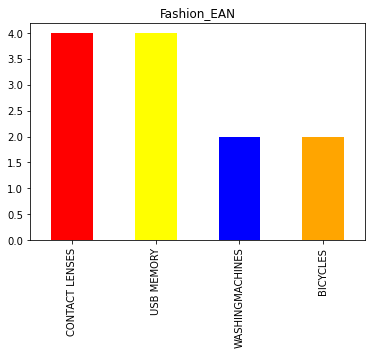

INTERN
USB MEMORY         1
WASHINGMACHINES    1
Name: productgroup, dtype: int64


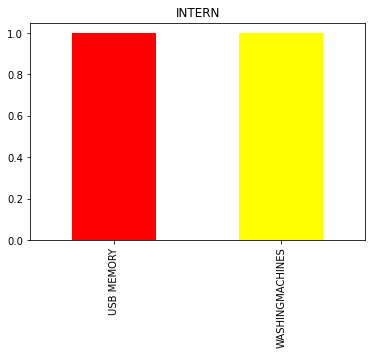

SAMSUNG
WASHINGMACHINES    58
USB MEMORY         17
Name: productgroup, dtype: int64


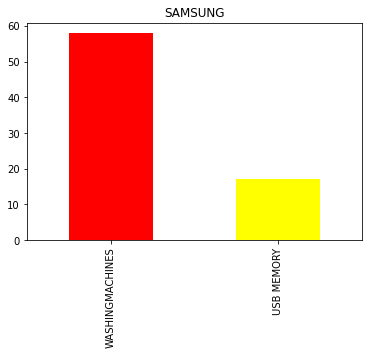

SONSTIGES
USB MEMORY    3
BICYCLES      3
Name: productgroup, dtype: int64


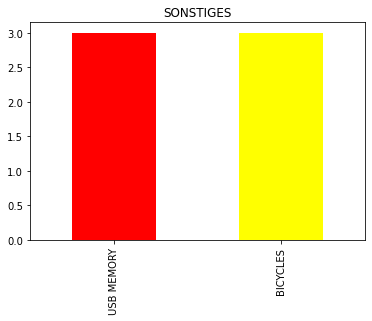

In [14]:
# display  manufacturer present in two different group
group_data=data.groupby(['manufacturer'])
for name,manufacture_data in group_data:
    if (manufacture_data['productgroup'].nunique()>1):
        print(name)
        print(manufacture_data['productgroup'].value_counts())
        #plt.figure(figsize=(10,10)) 
        manufacture_data['productgroup'].value_counts().plot(kind='bar', title=name ,color=['red', 'yellow', 'blue', 'orange'])
        plt.show()

In [15]:
# mising values per 'productgroup
data[data['manufacturer'].isna()]['productgroup'].value_counts()

BICYCLES           430
WASHINGMACHINES    404
USB MEMORY         277
CONTACT LENSES     233
Name: productgroup, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000237E699C288>,
      dtype=object)

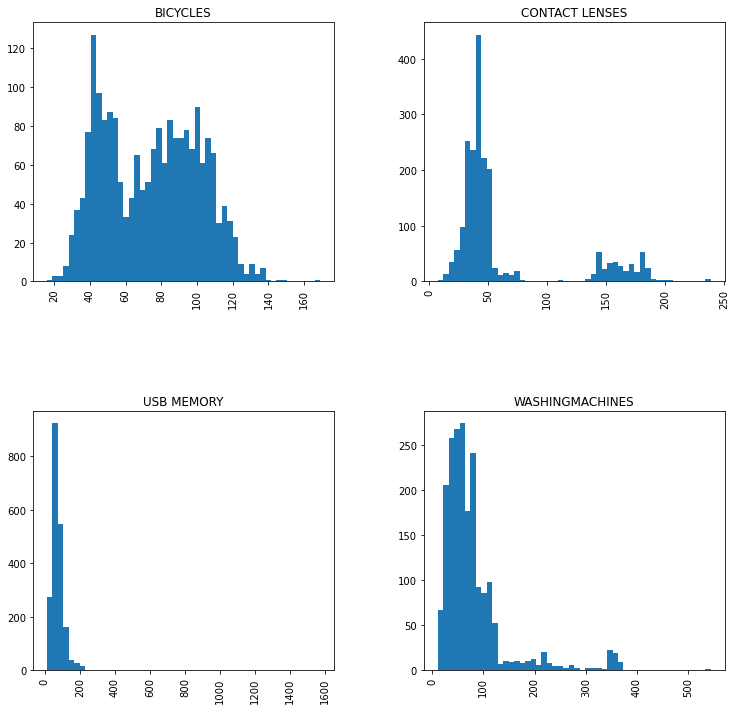

In [16]:
# histogram plot of length of description per productgroup
data_analysis.hist(column='length',by='productgroup',bins=50,figsize=(12,12))

169
239
1572
544


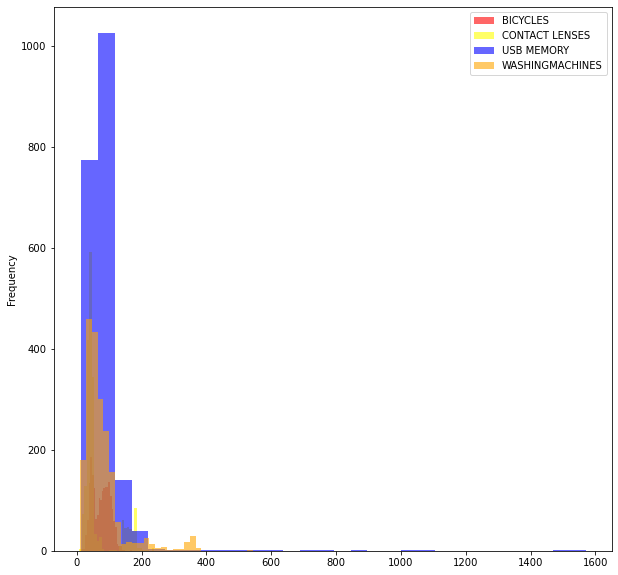

In [17]:
group_data=data_analysis.groupby(['productgroup'])
color=['red', 'yellow', 'blue', 'orange']
plt.figure(figsize=(10,10)) 
for i,(name,product_data) in enumerate(group_data):
    product_data['length'].plot(bins=30, kind='hist', color=color[i], label=name, alpha=0.6)
    plt.legend()
    print(product_data['description'].apply(len).max())
plt.show()

# Text pre-processing

In [18]:
# total number of characters in the description column
data_analysis['description'].apply(lambda x: len(x.split(' '))).sum()

76017

In [19]:
#data_analysis['description']=data_analysis['description'].apply(remove_punctuations)
#data_analysis['description']=data_analysis['description'].apply(remove_numbers)
#data_analysis['description']=data_analysis['description'].apply(remove_stopwords)
#data_analysis['description']=data_analysis['description'].apply(word_lem)
#data_analysis['description']=data_analysis['description'].apply(stemmer)

In [20]:
# new length of characters after text pre-processing
data_analysis['length']=data_analysis['description'].transform(len)
data_analysis.head()

,productgroup,manufacturer,description,length
0,WASHINGMACHINES,BOSCH,WAQ284E25 WASCHMASCHINEN,24
1,USB MEMORY,LEEF,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...,139
2,USB MEMORY,NaN,SANDISK 32GB ULTRA FIT USB 3.0 W1370,36
3,BICYCLES,SCHALOW & KROH GMBH,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3-GAENGE RH 5...,100
4,BICYCLES,DAHON,DAHON SPEED D7 SCHWARZ ? FALTRAD SPORTS__30000...,65


In [21]:
# total number of characters in the description column
data_analysis['description'].apply(lambda x: len(x.split())).sum()

72832

# Bag of words

In [22]:
#CountVectorizer
vector = CountVectorizer()
feature_vector=vector.fit_transform(data_analysis['description'])
feature_vector.shape

(8000, 8425)

In [23]:
# Term Frequency–Inverse Document Frequency
tfid_conv=TfidfTransformer()
tfid_vector=tfid_conv.fit_transform(feature_vector).toarray()
tfid_vector.shape

(8000, 8425)

In [24]:
#data_analysis['manufacturer']= data_analysis['manufacturer'].fillna('others')
#data_analysis.isna().sum()
#onehot_encoder = OneHotEncoder(sparse=False)
#encoded_result = onehot_encoder.fit_transform(data_analysis[['manufacturer']])
#print(encoded_result)
#print(onehot_encoder.categories_[0].shape)

In [25]:
data_analysis.head()

,productgroup,manufacturer,description,length
0,WASHINGMACHINES,BOSCH,WAQ284E25 WASCHMASCHINEN,24
1,USB MEMORY,LEEF,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...,139
2,USB MEMORY,NaN,SANDISK 32GB ULTRA FIT USB 3.0 W1370,36
3,BICYCLES,SCHALOW & KROH GMBH,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3-GAENGE RH 5...,100
4,BICYCLES,DAHON,DAHON SPEED D7 SCHWARZ ? FALTRAD SPORTS__30000...,65


# Training data preparation

In [26]:
x = data_analysis
y= data_analysis['productgroup']
x_train,x_test,y_train,y_test= train_test_split(x,y, test_size=0.25,random_state = 42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((6000, 4), (2000, 4), (6000,), (2000,))

In [27]:
# Using only description column for training
x_train = x_train['description']
x_test = x_test['description']

# Training pipeline

In [28]:
naive = Pipeline([('remove_punc',FunctionTransformer(pipeline_remove_punctuations, validate=False)),
                  ('remove_number',FunctionTransformer(pipeline_remove_numbers, validate=False)),
                  ('remove_stop',FunctionTransformer(pipeline_remove_stopwords, validate=False)),
                  ('word_lemeter',FunctionTransformer(pipeline_word_lem, validate=False)),
                  ('stemmer',FunctionTransformer(pipeline_stemmer, validate=False)),
                ('vector', CountVectorizer(min_df=5,ngram_range=(1,2))),
                ('tfid_vector', TfidfTransformer()),
                 ('model',MultinomialNB()),   
                 ])


# Training using Naive_baye model

In [29]:
naive.fit(x_train,y_train)
naive.get_params()

{'memory': None,
 'steps': [('remove_punc',
   FunctionTransformer(func=<function pipeline_remove_punctuations at 0x00000237E3B2FE58>)),
  ('remove_number',
   FunctionTransformer(func=<function pipeline_remove_numbers at 0x00000237E3D4BE58>)),
  ('remove_stop',
   FunctionTransformer(func=<function pipeline_remove_stopwords at 0x00000237E3D541F8>)),
  ('word_lemeter',
   FunctionTransformer(func=<function pipeline_word_lem at 0x00000237E3D540D8>)),
  ('stemmer',
   FunctionTransformer(func=<function pipeline_stemmer at 0x00000237E3D54318>)),
  ('vector', CountVectorizer(min_df=5, ngram_range=(1, 2))),
  ('tfid_vector', TfidfTransformer()),
  ('model', MultinomialNB())],
 'verbose': False,
 'remove_punc': FunctionTransformer(func=<function pipeline_remove_punctuations at 0x00000237E3B2FE58>),
 'remove_number': FunctionTransformer(func=<function pipeline_remove_numbers at 0x00000237E3D4BE58>),
 'remove_stop': FunctionTransformer(func=<function pipeline_remove_stopwords at 0x00000237E3D5

# Performance evaluation

In [30]:
y_true = np.array(y_test)
y_predict=naive.predict(x_test)
print('accuracy',accuracy_score(y_predict,y_true))
print(classification_report(y_true,y_predict))

accuracy 0.9915
                 precision    recall  f1-score   support

       BICYCLES       1.00      0.98      0.99       512
 CONTACT LENSES       0.98      1.00      0.99       491
     USB MEMORY       1.00      1.00      1.00       492
WASHINGMACHINES       0.99      0.99      0.99       505

       accuracy                           0.99      2000
      macro avg       0.99      0.99      0.99      2000
   weighted avg       0.99      0.99      0.99      2000



# Parameters tuning by Grid Search

In [31]:
tune_parameters ={'vector__ngram_range':[(1,1),(1,2),(2,2)],
              'tfid_vector__use_idf': (True, False), 
              'model__alpha': (1e-2, 1e-3, 1)}
naive_best=GridSearchCV(naive,tune_parameters,n_jobs=-1)
naive_best = naive_best.fit(x_train,y_train)
print(naive_best.best_score_)
print(naive_best.best_params_)

0.9911666666666668
{'model__alpha': 0.01, 'tfid_vector__use_idf': True, 'vector__ngram_range': (1, 1)}


In [32]:
# Performance evaluation for best scores
y_true = np.array(y_test)
print(x_test.shape)
y_predict=naive_best.predict(x_test)
print('accuracy',accuracy_score(y_predict,y_true))
print(classification_report(y_true,y_predict))

(2000,)
accuracy 0.992
                 precision    recall  f1-score   support

       BICYCLES       1.00      0.98      0.99       512
 CONTACT LENSES       0.98      1.00      0.99       491
     USB MEMORY       1.00      1.00      1.00       492
WASHINGMACHINES       0.99      0.99      0.99       505

       accuracy                           0.99      2000
      macro avg       0.99      0.99      0.99      2000
   weighted avg       0.99      0.99      0.99      2000



# Training pipeline with best parameters

In [33]:
naive_grid=Pipeline([('remove_punc',FunctionTransformer(pipeline_remove_punctuations, validate=False)),
                  ('remove_number',FunctionTransformer(pipeline_remove_numbers, validate=False)),
                  ('remove_stop',FunctionTransformer(pipeline_remove_stopwords, validate=False)),
                  ('word_lemeter',FunctionTransformer(pipeline_word_lem, validate=False)),
                  ('stemmer',FunctionTransformer(pipeline_stemmer, validate=False)),
                ('vector', CountVectorizer(min_df=5,ngram_range=(1,1))),
                ('tfid_vector', TfidfTransformer(use_idf=True)),
                 ('model',MultinomialNB(alpha=0.01)),])
naive_grid.fit(x_train,y_train)


Pipeline(steps=[('remove_punc',
                 FunctionTransformer(func=<function pipeline_remove_punctuations at 0x00000237E3B2FE58>)),
                ('remove_number',
                 FunctionTransformer(func=<function pipeline_remove_numbers at 0x00000237E3D4BE58>)),
                ('remove_stop',
                 FunctionTransformer(func=<function pipeline_remove_stopwords at 0x00000237E3D541F8>)),
                ('word_lemeter',
                 FunctionTransformer(func=<function pipeline_word_lem at 0x00000237E3D540D8>)),
                ('stemmer',
                 FunctionTransformer(func=<function pipeline_stemmer at 0x00000237E3D54318>)),
                ('vector', CountVectorizer(min_df=5)),
                ('tfid_vector', TfidfTransformer()),
                ('model', MultinomialNB(alpha=0.01))])

# Performance evaluation for best model 

In [34]:
y_true = np.array(y_test)
y_predict=naive_grid.predict(x_test)
print(type(y_predict))
print('accuracy',accuracy_score(y_predict,y_true))
print(classification_report(y_true,y_predict))

<class 'numpy.ndarray'>
accuracy 0.992
                 precision    recall  f1-score   support

       BICYCLES       1.00      0.98      0.99       512
 CONTACT LENSES       0.98      1.00      0.99       491
     USB MEMORY       1.00      1.00      1.00       492
WASHINGMACHINES       0.99      0.99      0.99       505

       accuracy                           0.99      2000
      macro avg       0.99      0.99      0.99      2000
   weighted avg       0.99      0.99      0.99      2000



# Evaluation Plot

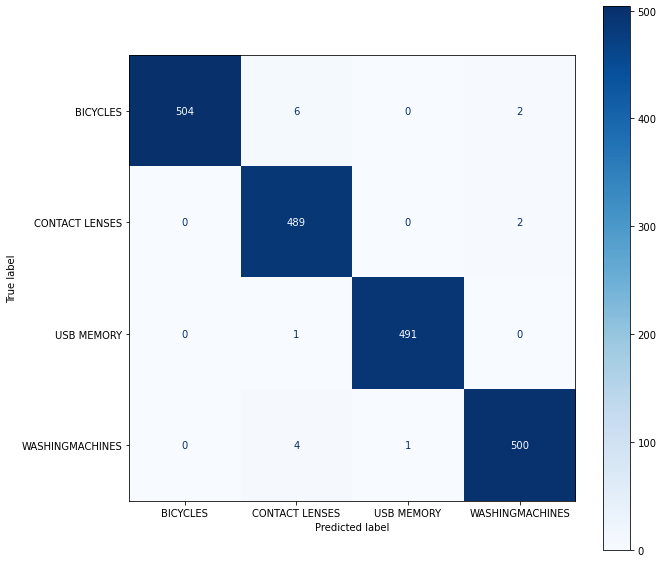

In [35]:
figure, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(naive_grid,x_test,y_test,cmap=plt.cm.Blues,ax=ax)
plt.show()

# Saving the trained model 

In [36]:

with open('trained_model/model.pickle', 'wb') as f:
    pickle.dump(naive_grid, f)

# Testing the Product Api Server

In [38]:
#input data
print(data_original.iloc[:3,:2])
x_test_api=data_original.iloc[:3]
payload = {'input_data': x_test_api.drop('productgroup',axis=1).to_json(orient='index')}
y_predict = requests.post('http://localhost:5000/products', json =payload)
print('result:', y_predict.json())

         id     productgroup
0  26229701  WASHINGMACHINES
1  16576864       USB MEMORY
2  26155618       USB MEMORY
result: {'prediction': {'16576864': 'USB MEMORY', '26155618': 'USB MEMORY', '26229701': 'WASHINGMACHINES'}, 'status': 'OK'}
